In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#plt.rcParams['figure.figsize'] = (14, 6)

In [2]:
# Useful functions
def to_col(x):   
    if len(x.shape)==1:
        x=x.reshape(x.shape[0],1)
    return x

def to_line(x):
    """ convert an vector to line vector if needed """
    if len(x.shape)==1:
        x=x.reshape(1,x.shape[0])
    return x        

def make_grid(data=None,xmin=-10,xmax=10,ymin=-10,ymax=10,step=100):
    """ Cree une grille sous forme de matrice 2d de la liste des points
    :param data: pour calcluler les bornes du graphe
    :param xmin: si pas data, alors bornes du graphe
    :param xmax:
    :param ymin:
    :param ymax:
    :param step: pas de la grille
    :return: une matrice 2d contenant les points de la grille
    """
    if data is not None:
        xmax, xmin, ymax, ymin = np.max(data[:,0]),  np.min(data[:,0]), np.max(data[:,1]), np.min(data[:,1])
    x, y =np.meshgrid(np.arange(xmin,xmax,(xmax-xmin)*1./step), np.arange(ymin,ymax,(ymax-ymin)*1./step))
    grid=np.c_[x.ravel(),y.ravel()]
    return grid, x, y


def plot_func_equal_level(f,level,axe,data=None,step=100):
    """ Trace un graphe de la frontiere de decision de f
    :param data: donnees
    :param f: fonction de decision
    :param step: pas de la grille
    :return:
    """
    grid,x,y=make_grid(data=data,step=step)
    axe.contour(x,y,f(grid).reshape(x.shape),colors=('blue'),levels=[level],zorder=3,linewidths=3)

def error(predicted,real_values):
    number_of_missclassified = np.sum(np.abs(predicted-real_values))
    percentage_error = round(number_of_missclassified/float(real_values.shape[0])*100,2)
    return number_of_missclassified,percentage_error

## Chargement des données

In [3]:
# Load tous les A_train, X_A_train,Y_A_train,B_train,X_B_train,Y_B_train ...
for cas in ["A","B","C"]:
    for type_set in ["train","test"]:
        exec(cas+"_"+type_set+"= np.loadtxt('classification_data_HWK1/classification"+cas+"."+type_set+"')")
        exec("X_"+cas+"_"+type_set+"="+cas+"_"+type_set+"[:,0:2]")
        exec("Y_"+cas+"_"+type_set+"=to_col("+cas+"_"+type_set+"[:,2])")

## 1. MLE Generative model (LDA)

In [4]:
# LDA functions to compute MLE of parameters and linear coeficients for the sigmoid func
def theta_MLE(Y):
    return(np.sum(Y)/Y.shape[0])

def mu_1_MLE(X,Y):
    return([np.sum(Y*to_col(X[:,0]))/np.sum(Y), np.sum(Y*to_col(X[:,1]))/np.sum(Y)])

def mu_0_MLE(X,Y): 
    return([(np.sum(X[:,0]) - np.sum(Y*to_col(X[:,0])))/(Y.shape[0]-np.sum(Y)), 
            (np.sum(X[:,1]) - np.sum(Y*to_col(X[:,1])))/(Y.shape[0]-np.sum(Y))])

def sigma_MLE(X,Y): 
    s1 = np.dot(np.transpose(Y)*np.transpose(X-mu_1_MLE(X,Y)),(X-mu_1_MLE(X,Y)))
    s0 = np.dot((np.ones(Y.shape[0])-np.transpose(Y))*np.transpose(X-mu_0_MLE(X,Y)),(X-mu_0_MLE(X,Y)))
    return((s1+s0)/Y.shape[0])

def compute_a(X,Y):
    return(np.dot(np.linalg.inv(sigma_MLE(X,Y)),np.asarray(mu_1_MLE(X,Y))-np.asarray(mu_0_MLE(X,Y))))

def compute_b(X,Y):
    return(np.log(theta_MLE(Y)/(1-theta_MLE(Y))) 
           -1/2*np.dot(np.dot((np.asarray(mu_1_MLE(X,Y))-np.asarray(mu_0_MLE(X,Y))),np.linalg.inv(sigma_MLE(X,Y)))
                ,(np.asarray(mu_0_MLE(X,Y))+np.asarray(mu_1_MLE(X,Y)))))


def LDA_prediction(X,a,b):
    return to_col(np.array([np.dot(a,x)+b>=0 for x in X]))

#### Compute MLE parameters

In [9]:
# definie a_A, a_B, a_c, b_A, ...
for cas in ["A","B","C"]:
    for parameters in ["a","b"]:
        exec(parameters+"_"+cas+"=compute_"+parameters+"(X_"+cas+"_train,Y_"+cas+"_train)")
        
    print("Sample "+cas+" :")
    print("theta_"+cas+"=",eval("theta_MLE(Y_"+cas+"_train)"))
    print("mu_1_"+cas+"=",eval("mu_1_MLE(X_"+cas+"_train,Y_"+cas+"_train)"))
    print("mu_0_"+cas+"=",eval("mu_0_MLE(X_"+cas+"_train,Y_"+cas+"_train)"))
    print("sigma_"+cas+"=",eval("sigma_MLE(X_"+cas+"_train,Y_"+cas+"_train)"))
    print("a_"+cas+"=", eval("a_"+cas))
    print("b_"+cas+"=", eval("b_"+cas))
    print()
    print()

Sample A :
('theta_A=', 0.33333333333333331)
('mu_1_A=', [-2.6923200424, 0.86604200000000031])
('mu_0_A=', [2.8997094650999999, -0.89387399999999995])
('sigma_A=', array([[ 2.44190897, -1.13194024],
       [-1.13194024,  0.61375465]]))
('a_A=', array([-6.62245258, -9.3462503 ]))
('b_A=', -0.6931471805599454)
()
()
Sample B :
('theta_B=', 0.5)
('mu_1_B=', [-3.2167073426666648, 1.0830673333333332])
('mu_0_B=', [3.3406889640666675, -0.83546333333333356])
('sigma_B=', array([[ 3.34623467, -0.13516489],
       [-0.13516489,  1.73807475]]))
('a_B=', array([-1.92108197,  0.95442836]))
('b_B=', 0.0)
()
()
Sample C :
('theta_C=', 0.625)
('mu_1_C=', [-2.9423288508399987, -0.95782840000000002])
('mu_0_C=', [2.7930482375999981, -0.83838666666666595])
('sigma_C=', array([[ 2.88039225, -0.63405081],
       [-0.63405081,  5.19952435]]))
('a_C=', array([-2.05129911, -0.27311529]))
('b_C=', 0.51082562376599072)
()
()


#### Apply to data

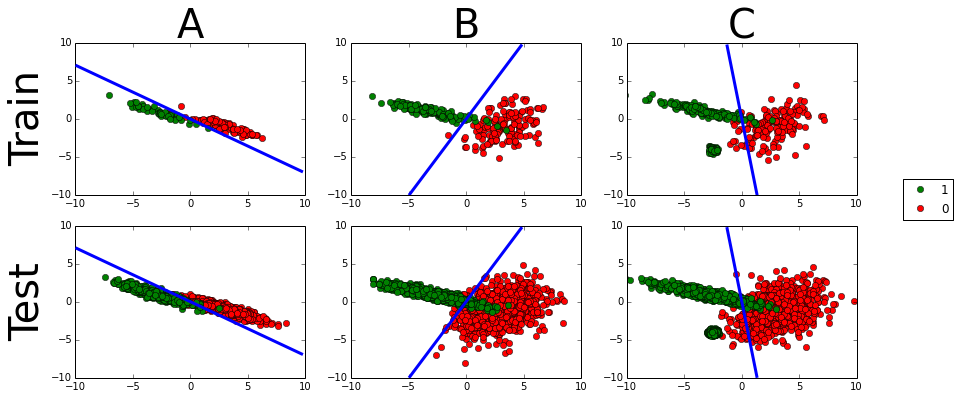

In [22]:
plt.rcParams['figure.figsize'] = (14, 6)
fig, axes = plt.subplots(2, 3)
axes[0][0].set_title("A",fontsize="40") 
axes[0][1].set_title("B",fontsize="40")
axes[0][2].set_title("C",fontsize="40")
axes[0][0].set_ylabel("Train",fontsize="40")
axes[1][0].set_ylabel("Test",fontsize="40")

Cases = ["A","B","C"]
Sets = ["train","test"]
for cas in Cases :
    # parametre de la ligne de decision 
    a = eval("a_"+cas)
    b = eval("b_"+cas)
    line = lambda x :np.dot(a,x)+b
    LDA_line_for_vect = lambda X :np.array([line(x) for x in X])
    # Affichage des données
    for s in Sets:
        # Affichage des points
        axes[Sets.index(s)][Cases.index(cas)].set_xlim(-10,10)
        axes[Sets.index(s)][Cases.index(cas)].set_ylim(-10,10)
        exec("X_"+cas+"_0 = X_"+cas+"_"+s+"[np.squeeze(Y_"+cas+"_"+s+"==0)]")
        exec("X_"+cas+"_1 = X_"+cas+"_"+s+"[np.squeeze(Y_"+cas+"_"+s+"==1)]")
        exec("red, = axes[Sets.index(s)][Cases.index(cas)].plot(X_"+cas+"_0[:,0],X_"+cas+"_0[:,1],'ro')")
        exec("green, = axes[Sets.index(s)][Cases.index(cas)].plot(X_"+cas+"_1[:,0],X_"+cas+"_1[:,1],'go')")

        # Affichage de la ligne de p(Y=1|X) = 0.5
        plot_func_equal_level(LDA_line_for_vect,0.5,axes[Sets.index(s)][Cases.index(cas)])
        
fig.legend((green,red),('1', '0'),'center right',numpoints = 1)
plt.show()

In [12]:
#calcul de l'erreur
Cases = ["A","B","C"]
Sets = ["train","test"]
for cas in Cases :
    for s in Sets:
        a = eval("a_"+cas)
        b = eval("b_"+cas)
        X = eval("X_"+cas+"_"+s)
        predicted = LDA_prediction(X,a,b)
        real_values = eval("Y_"+cas+"_"+s)
        number_of_missclassified,percentage_error = error(predicted,real_values)
        print(cas+" "+s+" : "+str(int(number_of_missclassified))+" points mal classifiés soit "+str(percentage_error)+" % d'erreur")
    print

A train : 1 points mal classifiés soit 0.67 % d'erreur
A test : 30 points mal classifiés soit 2.0 % d'erreur

B train : 9 points mal classifiés soit 3.0 % d'erreur
B test : 83 points mal classifiés soit 4.15 % d'erreur

C train : 22 points mal classifiés soit 5.5 % d'erreur
C test : 129 points mal classifiés soit 4.3 % d'erreur



## 2. Regression logistique

## 3. Regression lineaire

In [18]:
# linear regression functions for computing MLE of parameters
def omega_MLE(X,Y):
    XTX = np.dot(np.transpose(X),X)
    inv_XTX = np.linalg.inv(XTX)
    return np.dot(inv_XTX,np.dot(np.transpose(X),Y))

def add_colomn_1(X):
    nb_x = X.shape[0]
    dim = X.shape[1]
    new_X = np.ones((nb_x,dim+1))
    new_X[:,:-1] = X
    return new_X

def reg_lin_prediction(X,omega,b):
    return to_col(np.array([np.dot(np.transpose(omega),x)+b>=0.5 for x in X]))

In [19]:
Cases = ["A","B","C"]
Sets = ["train","test"]
for cas in Cases :
    omega_tild = omega_MLE(add_colomn_1(eval("X_"+cas+"_train")),eval("Y_"+cas+"_train"))
    exec("omega_"+cas+"= omega_tild[:-1]")
    exec("b_"+cas+"= omega_tild[-1]")
    
    print("Sample "+cas+" :")
    print("omega_"+cas+"= ", eval("omega_"+cas))
    print("b_"+cas+"= ", eval("b_"+cas))
    print()
    print()

Sample A :
('omega_A= ', array([[-0.2640075 ],
       [-0.37259311]]))
('b_A= ', array([ 0.49229204]))
()
()
Sample B :
('omega_B= ', array([[-0.10424575],
       [ 0.05179118]]))
('b_B= ', array([ 0.50005043]))
()
()
Sample C :
('omega_C= ', array([[-0.12769333],
       [-0.01700142]]))
('b_C= ', array([ 0.50839982]))
()
()


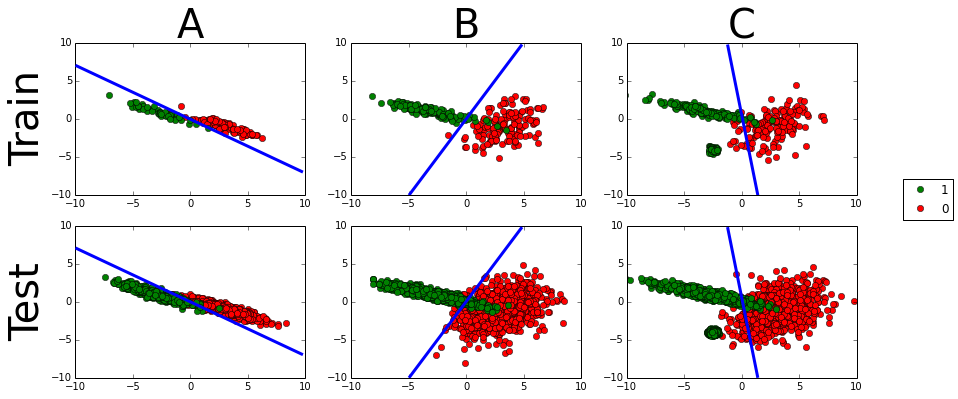

In [20]:
plt.rcParams['figure.figsize'] = (14, 6)
fig, axes = plt.subplots(2, 3)
axes[0][0].set_title("A",fontsize="40") 
axes[0][1].set_title("B",fontsize="40")
axes[0][2].set_title("C",fontsize="40")
axes[0][0].set_ylabel("Train",fontsize="40")
axes[1][0].set_ylabel("Test",fontsize="40")

# For compupting omega the omega_MLE function uses the solution for b = 0
# To get our omega and b we have to add a 1 at the end of each x
# Then omage is the vector until the before last coordinate and b is the last one
Cases = ["A","B","C"]
Sets = ["train","test"]
for cas in Cases :
    omega = eval("omega_"+cas)
    b = eval("b_"+cas)
    reg_lin_line = lambda X: np.array([np.dot(np.transpose(omega),x)+b for x in X])
    for s in Sets:
        # Affichage des points
        axes[Sets.index(s)][Cases.index(cas)].set_xlim(-10,10)
        axes[Sets.index(s)][Cases.index(cas)].set_ylim(-10,10)
        exec("X_"+cas+"_0 = X_"+cas+"_"+s+"[np.squeeze(Y_"+cas+"_"+s+"==0)]")
        exec("X_"+cas+"_1 = X_"+cas+"_"+s+"[np.squeeze(Y_"+cas+"_"+s+"==1)]")
        exec("red, = axes[Sets.index(s)][Cases.index(cas)].plot(X_"+cas+"_0[:,0],X_"+cas+"_0[:,1],'ro')")
        exec("green, = axes[Sets.index(s)][Cases.index(cas)].plot(X_"+cas+"_1[:,0],X_"+cas+"_1[:,1],'go')")
        
        # Affichage de la ligne de p(Y=1|X) = 0.5
        plot_func_equal_level(reg_lin_line,0.5,axes[Sets.index(s)][Cases.index(cas)])

fig.legend((green,red),('1', '0'),'center right',numpoints = 1)
plt.show()        

In [21]:
#calcul de l'erreur
Cases = ["A","B","C"]
Sets = ["train","test"]
for cas in Cases :
    for s in Sets:
        omega = eval("omega_"+cas)
        b = eval("b_"+cas)
        X = eval("X_"+cas+"_"+s)
        predicted = reg_lin_prediction(X,omega,b)
        real_values = eval("Y_"+cas+"_"+s)
        number_of_missclassified,percentage_error = error(predicted,real_values)
        print(cas+" "+s+" : "+str(int(number_of_missclassified))+" points mal classifiés soit "+str(percentage_error)+" % d'erreur")
    print

A train : 2 points mal classifiés soit 1.33 % d'erreur
A test : 31 points mal classifiés soit 2.07 % d'erreur

B train : 9 points mal classifiés soit 3.0 % d'erreur
B test : 83 points mal classifiés soit 4.15 % d'erreur

C train : 22 points mal classifiés soit 5.5 % d'erreur
C test : 127 points mal classifiés soit 4.23 % d'erreur



## 5. QDA model

In [10]:
# QDA functions to compute MLE of parameters and coeficients for the quadratic form
def sigma_0_MLE(X,Y):
    s0 =np.dot((np.ones(Y.shape[0])-np.transpose(Y))*np.transpose(X-mu_0_MLE(X,Y)),(X-mu_0_MLE(X,Y)))
    return(s0/(Y.shape[0]-np.sum(Y)))

def sigma_1_MLE(X,Y):
    s1 = np.dot(np.transpose(Y)*np.transpose(X-mu_1_MLE(X,Y)),(X-mu_1_MLE(X,Y)))
    return(s1/np.sum(Y))

def compute_c(X,Y):
    return(np.dot(np.linalg.inv(sigma_1_MLE(X,Y)),np.asarray(mu_1_MLE(X,Y)))
           -np.dot(np.linalg.inv(sigma_0_MLE(X,Y)),np.asarray(mu_0_MLE(X,Y))))


def compute_d(X,Y):
    return(np.log(theta_MLE(Y)/(1-theta_MLE(Y))) 
           + 1/2*np.log(np.linalg.det(sigma_0_MLE(X,Y))/np.linalg.det(sigma_1_MLE(X,Y)))
           + 1/2*np.dot(np.dot(np.asarray(mu_0_MLE(X,Y)),np.linalg.inv(sigma_0_MLE(X,Y))),np.asarray(mu_0_MLE(X,Y)))
           - 1/2*np.dot(np.dot(np.asarray(mu_1_MLE(X,Y)),np.linalg.inv(sigma_1_MLE(X,Y))),np.asarray(mu_1_MLE(X,Y))))
    
def compute_M(X,Y):
    return(np.linalg.inv(sigma_0_MLE(X,Y))-np.linalg.inv(sigma_1_MLE(X,Y)))

def QDA_eval_quad_vect(X,c,d,M):
    return np.array([QDA_eval_quad(x,c,d,M) for x in X])

def QDA_eval_quad(x,c,d,M):
    return np.array(1.0/2*np.dot(np.dot(x,M),x)+np.dot(c,x)+d)

def QDA_prediction(X,c,d,M):
    return to_col(np.array([QDA_eval_quad(x,c,d,M)>=0 for x in X]))



#### Compute MLE parameters

In [11]:
# definie c_A, c_B, c_D, d_A, ...
for cas in ["A","B","C"]:
    for parameters in ["c","d","M"]:
        exec(parameters+"_"+cas+"=compute_"+parameters+"(X_"+cas+"_train,Y_"+cas+"_train)")
        
    print("Sample "+cas+" :")
    print("theta_"+cas+"=",eval("theta_MLE(Y_"+cas+"_train)"))
    print("mu_1_"+cas+"=",eval("mu_1_MLE(X_"+cas+"_train,Y_"+cas+"_train)"))
    print("mu_0_"+cas+"=",eval("mu_0_MLE(X_"+cas+"_train,Y_"+cas+"_train)"))
    print("sigma_0"+cas+"=",eval("sigma_0_MLE(X_"+cas+"_train,Y_"+cas+"_train)"))
    print("sigma_1"+cas+"=",eval("sigma_1_MLE(X_"+cas+"_train,Y_"+cas+"_train)"))
    print("c_"+cas+"=", eval("c_"+cas))
    print("d_"+cas+"=", eval("d_"+cas))
    print("M_"+cas+"=", eval("M_"+cas))
    print()
    print()

Sample A :
('theta_A=', 0.33333333333333331)
('mu_1_A=', [-2.6923200424, 0.86604200000000031])
('mu_0_A=', [2.8997094650999999, -0.89387399999999995])
('sigma_0A=', array([[ 2.31065259, -1.04748461],
       [-1.04748461,  0.57578403]]))
('sigma_1A=', array([[ 2.70442172, -1.3008515 ],
       [-1.3008515 ,  0.68969588]]))
('c_A=', array([ -7.36527314, -10.87335416]))
('d_A=', -0.6931471805599454)
('M_A=', array([[-1.51744039, -3.0272297 ],
       [-3.0272297 , -5.72332675]]))
()
()
Sample B :
('theta_B=', 0.5)
('mu_1_B=', [-3.2167073426666648, 1.0830673333333332])
('mu_0_B=', [3.3406889640666675, -0.83546333333333356])
('sigma_0B=', array([[ 2.53885859,  1.0642112 ],
       [ 1.0642112 ,  2.96007891]]))
('sigma_1B=', array([[ 4.15361075, -1.33454097],
       [-1.33454097,  0.51607059]]))
('c_B=', array([-2.28065009,  1.45700199]))
('d_B=', 0.0)
('M_B=', array([[ -0.95965255,  -3.84765056],
       [ -3.84765056, -11.05867014]]))
()
()
Sample C :
('theta_C=', 0.625)
('mu_1_C=', [-2.942328

#### Apply to data

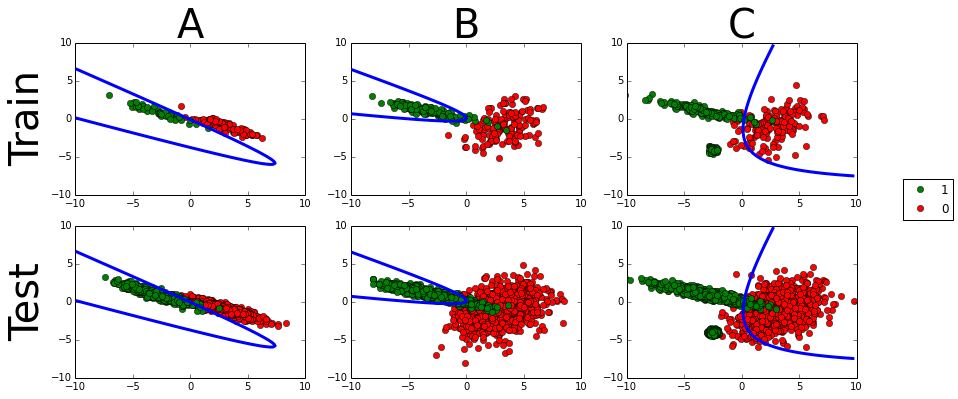

In [12]:
plt.rcParams['figure.figsize'] = (14, 6)
fig, axes = plt.subplots(2, 3)
axes[0][0].set_title("A",fontsize="40") 
axes[0][1].set_title("B",fontsize="40")
axes[0][2].set_title("C",fontsize="40")
axes[0][0].set_ylabel("Train",fontsize="40")
axes[1][0].set_ylabel("Test",fontsize="40")

Cases = ["A","B","C"]
Sets = ["train","test"]
for cas in Cases :
    c = eval("c_"+cas)
    d = eval("d_"+cas)
    M = eval("M_"+cas)
    quad_decision_func = lambda x:QDA_eval_quad_vect(x,c,d,M)
    for s in Sets:
        # Affichage des données
        axes[Sets.index(s)][Cases.index(cas)].set_xlim(-10,10)
        axes[Sets.index(s)][Cases.index(cas)].set_ylim(-10,10)
        exec("X_"+cas+"_0 = X_"+cas+"_"+s+"[np.squeeze(Y_"+cas+"_"+s+"==0)]")
        exec("X_"+cas+"_1 = X_"+cas+"_"+s+"[np.squeeze(Y_"+cas+"_"+s+"==1)]")
        exec("red, = axes[Sets.index(s)][Cases.index(cas)].plot(X_"+cas+"_0[:,0],X_"+cas+"_0[:,1],'ro')")
        exec("green, = axes[Sets.index(s)][Cases.index(cas)].plot(X_"+cas+"_1[:,0],X_"+cas+"_1[:,1],'go')")
        
        # Affichage de la courbe de p(Y=1|X) = 0.5
        plot_func_equal_level(quad_decision_func,0,axes[Sets.index(s)][Cases.index(cas)])
        
#    plot_frontiere(eval("X_"+cas+"_"+s),lambda x:QDA_eval_quad_vect(x,c,d,M),axes[0][Cases.index(cas)],100)
 #   plot_frontiere(eval("X_"+cas+"_"+s),lambda x:QDA_eval_quad_vect(x,c,d,M),axes[1][Cases.index(cas)],100)
fig.legend((green,red),('1', '0'),'center right',numpoints = 1)
plt.show()

In [15]:
#calcul de l'erreur
Cases = ["A","B","C"]
Sets = ["train","test"]
for cas in Cases :
    for s in Sets:
        c = eval("c_"+cas)
        d = eval("d_"+cas)
        M = eval("M_"+cas)
        X = eval("X_"+cas+"_"+s)
        predicted = QDA_prediction(X,c,d,M)
        real_values = eval("Y_"+cas+"_"+s)
        number_of_missclassified,percentage_error = error(predicted,real_values)
        print(cas+" "+s+" : "+str(int(number_of_missclassified))+" points mal classifiés soit "+str(percentage_error)+" % d'erreur")
    print

A train : 1 points mal classifiés soit 0.67 % d'erreur
A test : 29 points mal classifiés soit 1.93 % d'erreur

B train : 11 points mal classifiés soit 3.67 % d'erreur
B test : 82 points mal classifiés soit 4.1 % d'erreur

C train : 21 points mal classifiés soit 5.25 % d'erreur
C test : 121 points mal classifiés soit 4.03 % d'erreur



In [122]:
#LDA(X_A_train, Y_A_train)

In [ ]:
Theta_MLE_A = (1.0/np.shape(A_train)[0])*sum([a[2] for a in A_train])
Theta_MLE_B = (1.0/np.shape(B_train)[0])*sum([b[2] for b in B_train])
Theta_MLE_C = (1.0/np.shape(C_train)[0])*sum([c[2] for c in C_train])

print Theta_MLE_A
print Theta_MLE_B
print Theta_MLE_C

mu_0_MLE_A = np.sum([(1-a[2])*np.array([a[0],a[1]]) for a in A_train],axis = 0)/sum([(1-a[2]) for a in A_train])
mu_0_MLE_B = np.sum([(1-b[2])*np.array([b[0],b[1]]) for b in B_train],axis = 0)/sum([(1-b[2]) for b in B_train])
mu_0_MLE_C = np.sum([(1-c[2])*np.array([c[0],c[1]]) for c in C_train],axis = 0)/sum([(1-c[2]) for c in C_train])

print mu_0_MLE_A
print mu_0_MLE_B
print mu_0_MLE_C

mu_1_MLE_A = np.sum([a[2]*np.array([a[0],a[1]]) for a in A_train],axis = 0)/sum([a[2] for a in A_train])
mu_1_MLE_B = np.sum([b[2]*np.array([b[0],b[1]]) for b in B_train],axis = 0)/sum([b[2] for b in B_train])
mu_1_MLE_C = np.sum([c[2]*np.array([c[0],c[1]]) for c in C_train],axis = 0)/sum([c[2] for c in C_train])

print mu_1_MLE_A
print mu_1_MLE_B
print mu_1_MLE_C

def p_Y1_X(x,theta,mu_0,mu_1,sigma):#x vecteur vertical
    return( 1.0/(1.0+((1.0-theta)/(theta))*exp((((mu_0+mu_1)[np.newaxis]).T).dot(sigma).dot(x) - (1.0/2)*((mu_0.T).dot(sigma).dot(mu_0) + (mu_1.T).dot(sigma).dot(mu_1))))
    

In [ ]:
print A_train[:3]

In [ ]:
print [np.array([a[0],a[1]]) for a in A_train][:2]

In [ ]:
a = np.array([1,2])
b = np.array([[3,4],[5,6]])
print np.transpose(a[np.newaxis])*b

In [ ]:
#transformer un vecteur ligne en colone
vecteur_ligne = np.array([1,2,3])
vecteur_colone = np.transpose(vecteur_ligne[np.newaxis])
print vecteur_ligne
print np.transpose(vecteur_colone).dot(np.array([[1,2,0],[0,1,0],[0,0,1]])).dot(vecteur_colone)

print vecteur_colone.T

In [13]:
def para(X): 
    return np.array([ x[0]**2 + x[1]**2 -2 for x in X])

In [23]:
nb_x = X_A_train.shape[0]
dim = X_A_train.shape[1]
b = np.ones((nb_x,dim+1))
b[:,:-1] = X_A_train


(150, 1)
[[-3.60340505  1.3266      1.        ]
 [-4.2190114   2.015       1.        ]
 [-1.51565812  0.5059      1.        ]
 [-1.16975695  0.3815      1.        ]
 [ 0.52274116 -0.6572      1.        ]
 [-0.14174035 -0.7083      1.        ]
 [-3.2644966   1.312       1.        ]
 [-1.7093627   0.2236      1.        ]
 [-2.06451872  0.6392      1.        ]
 [-2.7745778   1.139       1.        ]
 [-4.4637327   1.2861      1.        ]
 [-2.05557939  0.716       1.        ]
 [-4.93081485  1.9442      1.        ]
 [-2.78573378  0.8165      1.        ]
 [-3.78492412  1.0945      1.        ]
 [-0.023503   -0.1801      1.        ]
 [-4.0787268   1.6789      1.        ]
 [-4.88879174  2.2006      1.        ]
 [-4.11260798  1.3405      1.        ]
 [-5.11303227  1.578       1.        ]
 [-2.76271871  0.6868      1.        ]
 [-7.08295715  3.1183      1.        ]
 [-2.10955767  0.7613      1.        ]
 [-0.77900674 -0.1129      1.        ]
 [-4.72843487  1.5547      1.        ]
 [-2.63444768  0